<a href="https://colab.research.google.com/github/prog815/traide/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%20%D0%BD%D0%B0%20%D0%B2%D1%81%D1%8E%20%D0%B4%D0%BB%D0%B8%D0%BD%D1%83%20NN(%D0%B2%D1%8B%D1%85%D0%BE%D0%B4%20%D0%BD%D0%B0%20%D0%BF%D0%BB%D0%B0%D1%82%D0%BE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз на всю длину (выход на плато)


---

добавляем немного тонкой настройки в виде выхода на плато

# Подключаем библиотеки

In [1]:
! pip install keras-tuner --upgrade
! pip install yfinance
! pip install git+https://github.com/prog815/progOrder

     |████████████████████████████████| 102kB 6.4MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=ae02b15bbad5efb65fb486e2f33fc1edd8ae654b4c480b69397f16e0d194e9f2
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy
     |████████████████████████████████| 6.3MB 11.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=62063a34dd29681a37374e9c4b2b534fc56d81ed2802bc1d823dfa8d2bbc9224
  Stored in directory: /root/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-1vzbfq05
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-1vzbfq05
  Created wheel 

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import sklearn.metrics as metrics
import progOrder
import sklearn.model_selection as sl_ms
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
import keras_tuner as kt

# Загрузка котировок

## список тикеров

In [3]:
acc_list = "TGKA	FEES	VTBR	TGKB	HYDR	TGKD	TGKN	RSTI	ENRU	SNGS	MRKV	GAZP	MRKZ	MRKP	SNGSP	MAGN	TGKDP	MSNG	MRKC	MRKU	NMTP	NLMK	MTLR	AFLT	MSRS	ROSN	TTLK	FESH	TRMK	RSTIP	RTKM	SIBN	AMEZ	ISKJ	DVEC	RASP	RTKMP	UTAR	LSNG	BSPB	MRKS	MVID	NKNCP	LSNGP	PIKK	KMAZ	IRKT	SVAV	CHEP	MRKK	KUBE	ROSB	KROT".split('\t')
acc_list = [f'{name}.ME' for name in acc_list]
np.array(acc_list)

array(['TGKA.ME', 'FEES.ME', 'VTBR.ME', 'TGKB.ME', 'HYDR.ME', 'TGKD.ME',
       'TGKN.ME', 'RSTI.ME', 'ENRU.ME', 'SNGS.ME', 'MRKV.ME', 'GAZP.ME',
       'MRKZ.ME', 'MRKP.ME', 'SNGSP.ME', 'MAGN.ME', 'TGKDP.ME', 'MSNG.ME',
       'MRKC.ME', 'MRKU.ME', 'NMTP.ME', 'NLMK.ME', 'MTLR.ME', 'AFLT.ME',
       'MSRS.ME', 'ROSN.ME', 'TTLK.ME', 'FESH.ME', 'TRMK.ME', 'RSTIP.ME',
       'RTKM.ME', 'SIBN.ME', 'AMEZ.ME', 'ISKJ.ME', 'DVEC.ME', 'RASP.ME',
       'RTKMP.ME', 'UTAR.ME', 'LSNG.ME', 'BSPB.ME', 'MRKS.ME', 'MVID.ME',
       'NKNCP.ME', 'LSNGP.ME', 'PIKK.ME', 'KMAZ.ME', 'IRKT.ME', 'SVAV.ME',
       'CHEP.ME', 'MRKK.ME', 'KUBE.ME', 'ROSB.ME', 'KROT.ME'], dtype='<U8')

## Загрузка из сети

In [4]:
all_data = yf.download(acc_list,period='10y',threads=False)


[*********************100%***********************]  53 of 53 completed


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2011-07-12 to 2021-07-12
Columns: 318 entries, ('Adj Close', 'AFLT.ME') to ('Volume', 'VTBR.ME')
dtypes: float64(318)
memory usage: 6.1 MB


In [6]:
all_data

Adj Close                      ...     Volume                       
              AFLT.ME AMEZ.ME     BSPB.ME  ...    TTLK.ME  UTAR.ME       VTBR.ME
Date                                       ...                                  
2011-07-12  51.479931  13.209   99.052391  ...       50.0    444.0  3.290454e+06
2011-07-13  51.384876  13.380   99.909012  ...      127.0    185.0  4.021595e+06
2011-07-14  51.202076  13.436  100.351585  ...      482.0    433.0  2.785689e+06
2011-07-15  50.968121  13.433  100.337296  ...      128.0    173.0  4.411285e+06
2011-07-18  50.551369  13.372  100.137451  ...       60.0     44.0  3.326645e+06
...               ...     ...         ...  ...        ...      ...           ...
2021-07-06  68.400002  11.225   66.019997  ...  4140000.0   6900.0  5.527354e+10
2021-07-07  68.300003  11.225   66.019997  ...  2570000.0  36700.0  4.482605e+10
2021-07-08  67.940002  11.085   65.500000  ...  4330000.0   5300.0  4.166873e+10
2021-07-09  68.839996  11.160   66.900002  ...  3520000.0   5300.0  3.190898e+10
2021-07-12  68.860001  11.190   66.900002  ...  2130000.0   4100.0  2.834958e+10

[2507 rows x 318 columns]

# Выход ордерный



---



Генерим выход.

На выходе: 
- "-1" - продавать
- 0 - держать
- "+1" - покупать

Генерим для каждого инструмента.


---



In [7]:
res = []
for acc in acc_list:
    ohlc = all_data.loc[:,[['Open',acc],['High',acc],['Low',acc],['Close',acc]]].values
    buy,sell = progOrder.getBuySellForData(ohlc,dSL=0.1,SP=0.0007)
    y = buy-sell
    res.append(y)
Y = np.array(res).T

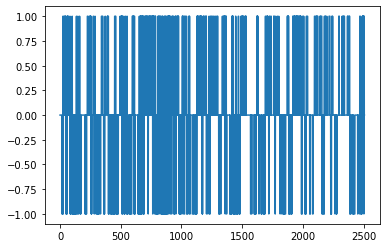

In [8]:
plt.plot(Y[:,12])



---


На образце по 12-му инструменту часто пляшет изменение



---



In [9]:
for n in range(Y.shape[1]):
    print(acc_list[n],np.unique(Y[:,n],return_counts=True))

TGKA.ME (array([-1.,  0.,  1.]), array([ 567, 1467,  473]))
FEES.ME (array([-1.,  0.,  1.]), array([ 179, 2135,  193]))
VTBR.ME (array([-1.,  0.,  1.]), array([ 458, 1640,  409]))
TGKB.ME (array([0.]), array([2507]))
HYDR.ME (array([-1.,  0.,  1.]), array([  89, 2359,   59]))
TGKD.ME (array([-1.,  0.,  1.]), array([ 117, 2337,   53]))
TGKN.ME (array([0.]), array([2507]))
RSTI.ME (array([-1.,  0.,  1.]), array([  90, 2330,   87]))
ENRU.ME (array([-1.,  0.,  1.]), array([  85, 2354,   68]))
SNGS.ME (array([-1.,  0.,  1.]), array([  55, 2414,   38]))
MRKV.ME (array([-1.,  0.,  1.]), array([ 441, 1660,  406]))
GAZP.ME (array([-1.,  0.,  1.]), array([  60, 2405,   42]))
MRKZ.ME (array([-1.,  0.,  1.]), array([ 393, 1703,  411]))
MRKP.ME (array([-1.,  0.,  1.]), array([ 182, 2086,  239]))
SNGSP.ME (array([-1.,  0.,  1.]), array([  68, 2401,   38]))
MAGN.ME (array([-1.,  0.,  1.]), array([  79, 2396,   32]))
TGKDP.ME (array([-1.,  0.]), array([   2, 2505]))
MSNG.ME (array([-1.,  0.,  1.]), ar

# Входы с задержкой

## Анализ входов

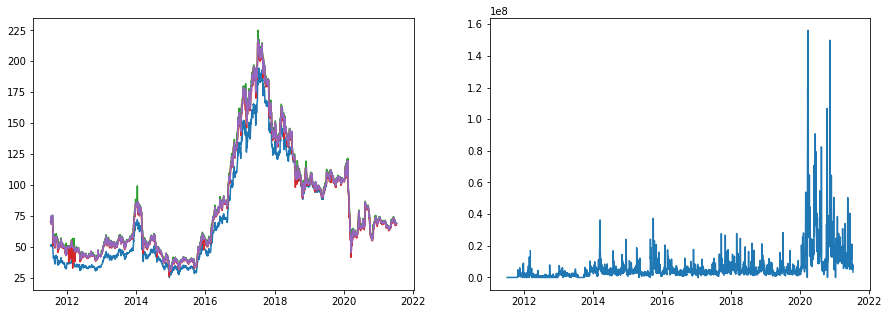

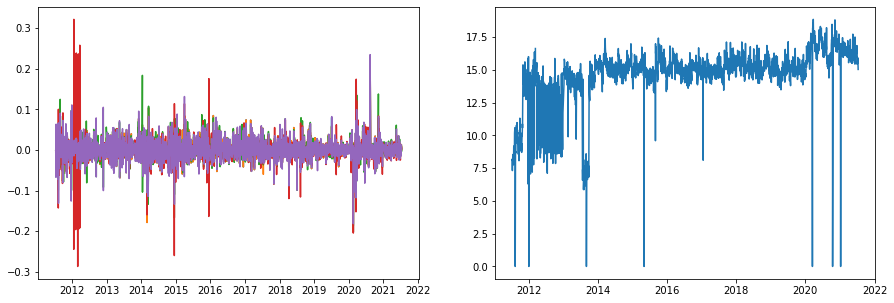

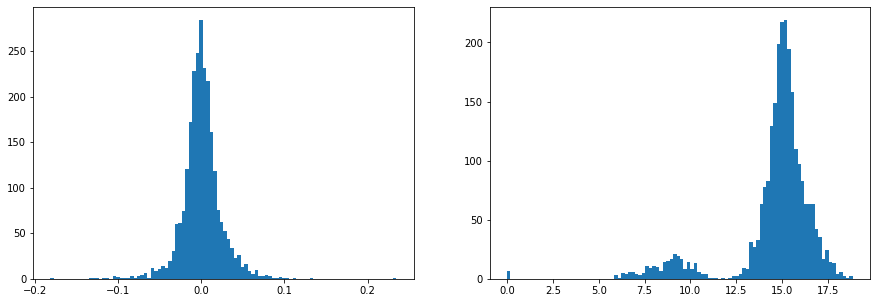

In [10]:
sample_acc = np.random.choice(acc_list)
sample_data = all_data[[(gr,sample_acc) for gr in np.unique([gr for gr,acc in all_data.columns])]]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(sample_data.iloc[:,:-1])
plt.subplot(1,2,2)
plt.plot(sample_data.iloc[:,-1])
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(sample_data.iloc[:,:-1].pct_change())
plt.subplot(1,2,2)
plt.plot(sample_data.iloc[:,-1].apply(np.log1p))
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(sample_data.iloc[:,-2].pct_change(),bins=100)
plt.subplot(1,2,2)
plt.hist(sample_data.iloc[:,-1].apply(np.log1p),bins=100)
plt.show()

можно для котировок использовать изменение, а для объемов использовать логарифмическое преобразование

## Преобразование

In [11]:
dData = all_data.copy()
aohlc = dData.iloc[:,:-int(len(dData.columns)/6)]
aohlc.iloc[:,:] = aohlc.pct_change()
v = dData.iloc[:,-int(len(dData.columns)/6):]
v.iloc[:,:] = v.apply(np.log1p)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [12]:
dData.isna().sum().max()

290

максимальное число пустых элементов в столбце

не много

можно заполнить

## карты

In [13]:
all_len,mapsCnt = dData.shape
zad = 40
X_maps = np.zeros((all_len,zad,mapsCnt))
for n in range(zad):
    X_maps[:,n,:] = dData.shift(n).values

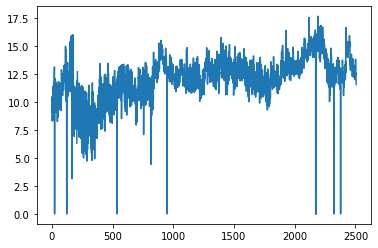

In [14]:
plt.plot(X_maps[:,0,-4])

## Даты

In [15]:
X_date = np.hstack([np.array([dData.index.day.values/31,dData.index.weekday.values/7,dData.index.month/12]).T])
X_date = np.hstack([np.sin(X_date),np.cos(X_date)])
X_date.shape

(2507, 6)

# Обучение и тест (делим выборки)

In [16]:
X_maps_train, X_maps_test, X_date_train, X_date_test, Y_train, Y_test = sl_ms.train_test_split(X_maps,X_date,Y,test_size=0.2,shuffle=False)

for n in range(X_maps_train.shape[2]):
    mean = np.nanmean(X_maps_train[:,:,n])
    X_maps_train[:,:,n] -= mean
    X_maps_test[:,:,n] -= mean
    std = np.nanstd(X_maps_train[:,:,n])
    X_maps_train[:,:,n] /= std if std > 1e-5 else 1
    X_maps_test[:,:,n] /= std if std > 1e-5 else 1
    # break
    
X_maps_train[np.isnan(X_maps_train)] = 0

In [17]:
X_maps_train.shape, X_maps_test.shape, X_date_train.shape, X_date_test.shape, Y_train.shape, Y_test.shape

((2005, 40, 318), (502, 40, 318), (2005, 6), (502, 6), (2005, 53), (502, 53))

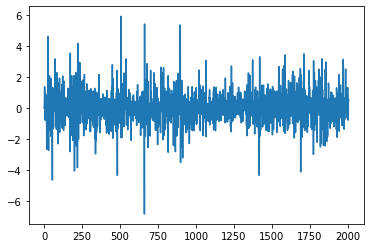

In [18]:
plt.plot(X_maps_train[:,1,40])

# Учим - тестим

## Обучение

In [23]:
def build_model(hp):
    inputMaps = keras.Input(X_maps_train[0].shape,name='inputMaps')
    inputDate = keras.Input(X_date_train[0].shape,name='inputDate')

    xMaps = keras.layers.Conv1D(filters=hp.Choice('filters1',range(10,200,10)),
                                kernel_size=hp.Choice('kernel1',[2,3,4,5]),
                                input_shape=X_maps_train[0].shape,
                                activation=tf.nn.sigmoid)(inputMaps)
    xMaps = keras.layers.MaxPool1D()(xMaps)
    xMaps = keras.layers.BatchNormalization()(xMaps)
    xMaps = keras.layers.Conv1D(filters=hp.Choice('filters2',range(10,200,10)),
                                kernel_size=hp.Choice('kernel2',[2,3,4,5]),
                                input_shape=X_maps_train[0].shape,
                                activation=tf.nn.sigmoid)(xMaps)
    xMaps = keras.layers.MaxPool1D()(xMaps)
    xMaps = keras.layers.Dropout(hp.Choice('dropout',list(np.logspace(-2,-0.5,10))))(xMaps)
    xMaps = keras.layers.Flatten()(xMaps)

    x = keras.layers.concatenate([xMaps,inputDate])

    x = keras.layers.Dense(hp.Choice('dense',range(10,200,10)),activation=tf.nn.sigmoid)(x)
    output = keras.layers.Dense(3,activation=tf.nn.softmax)(x)

    model = keras.Model(inputs={'inputMaps':inputMaps,'inputDate':inputDate},outputs=output)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp.Choice('learning_rate',list(np.logspace(-4,-2)))),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    
    return model

tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=40,
                        overwrite=True
                        )

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_train[:,0]+1),
                                                  Y_train[:,0]+1)

cb_es = keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True,verbose=1)
cb_pt = keras.callbacks.ReduceLROnPlateau(verbose=1,patience=10)


tuner.search(x={'inputMaps':X_maps_train,'inputDate':X_date_train},
             y=Y_train[:,0]+1,
             epochs=300,
             verbose=True,
             validation_split=0.3,
             callbacks=[cb_es,cb_pt],
             class_weight={k:v for k,v in zip(np.unique(Y_train[:,0]+1),class_weights)})

bhp = tuner.get_best_hyperparameters()[0]

print(bhp.values)

model = build_model(bhp)

model.fit(x={'inputMaps':X_maps_train,'inputDate':X_date_train},
          y=Y_train[:,0]+1,
          epochs=100,
          verbose=True,
          validation_split=0.3,
          callbacks=[cb_es,cb_pt],
          class_weight={k:v for k,v in zip(np.unique(Y_train[:,0]+1),class_weights)}
          )

Trial 40 Complete [00h 00m 36s]
val_loss: 1.0748738050460815

Best val_loss So Far: 1.0601177215576172
Total elapsed time: 00h 14m 26s
INFO:tensorflow:Oracle triggered exit
{'filters1': 80, 'kernel1': 5, 'filters2': 100, 'kernel2': 4, 'dropout': 0.046415888336127774, 'dense': 30, 'learning_rate': 0.0002811768697974231}
Epoch 1/100
44/44 [==============================] - 1s 9ms/step - loss: 0.8141 - val_loss: 1.1338
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.7164 - val_loss: 1.1232
Epoch 3/100
44/44 [==============================] - 0s 6ms/step - loss: 0.6295 - val_loss: 1.1363
Epoch 4/100
44/44 [==============================] - 0s 6ms/step - loss: 0.5965 - val_loss: 1.1226
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.5763 - val_loss: 1.1247
Epoch 6/100
44/44 [==============================] - 0s 6ms/step - loss: 0.5636 - val_loss: 1.1136
Epoch 7/100
44/44 [==============================] - 0s 6ms/step - loss: 0.5524 - val

## Тестирование

In [24]:
Y_pred_train = np.argmax(model.predict({'inputMaps':X_maps_train,'inputDate':X_date_train}),axis=1)-1
Y_pred_test = np.argmax(model.predict({'inputMaps':X_maps_test,'inputDate':X_date_test}),axis=1)-1
print('------------ train -----------')
print(classification_report(Y_train[:,0],Y_pred_train))
print('------------ test -----------')
print(classification_report(Y_test[:,0],Y_pred_test))

------------ train -----------
              precision    recall  f1-score   support

        -1.0       0.53      0.82      0.65       398
         0.0       0.94      0.86      0.90      1361
         1.0       0.69      0.43      0.53       246

    accuracy                           0.80      2005
   macro avg       0.72      0.70      0.69      2005
weighted avg       0.83      0.80      0.80      2005

------------ test -----------
              precision    recall  f1-score   support

        -1.0       0.44      0.57      0.50       169
         0.0       0.29      0.24      0.26       106
         1.0       0.47      0.41      0.44       227

    accuracy                           0.43       502
   macro avg       0.40      0.41      0.40       502
weighted avg       0.42      0.43      0.42       502



## Схема сети

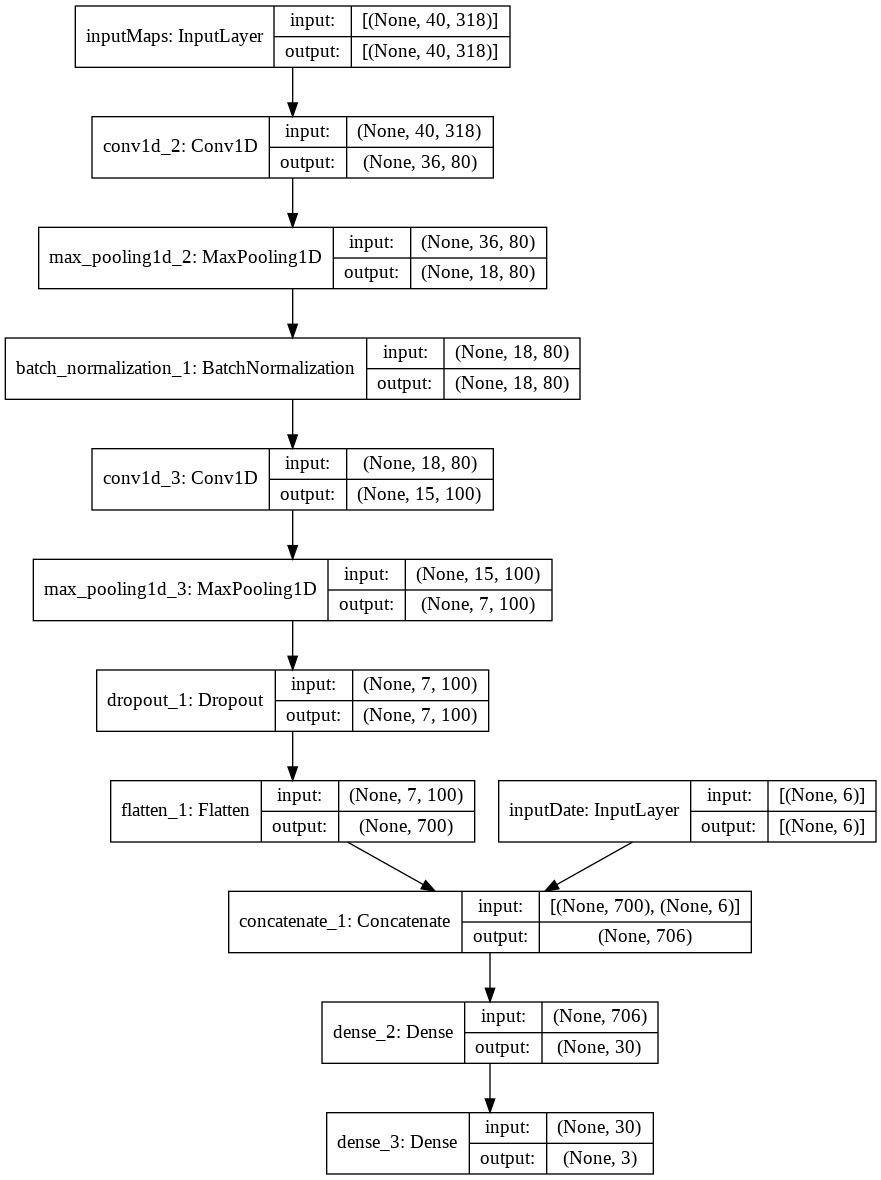

In [25]:
keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)